In [1]:
import numpy as np
import pandas as pd

from constants import*
from IPython.core.display import HTML, display
from bokeh.plotting import figure, show, output_notebook, vplot, hplot, save
from bokeh.models import HoverTool, TapTool, ColumnDataSource, Patches, Plot, Range1d, Callback, Slider, DateRangeSlider, Dropdown, Text, Circle, LinearAxis, SingleIntervalTicker, Rect 
from bokeh.models.widgets import Tabs, Panel
from bokeh.resources import CDN
from bokeh.embed import file_html

__version__ = "ny_counties_build_1.1"


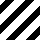
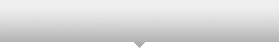
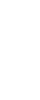
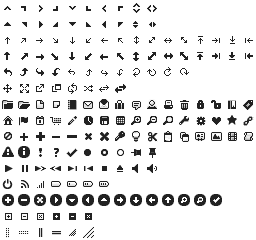
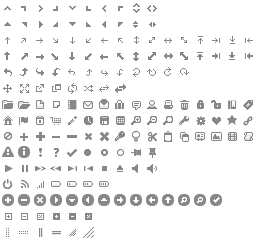
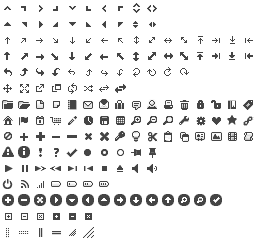
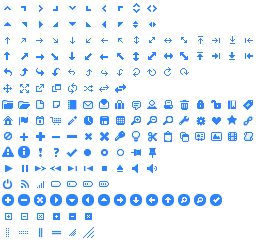
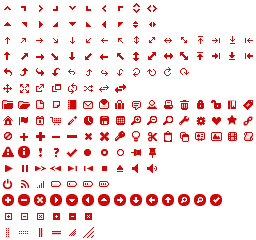
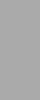
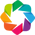
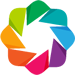
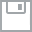
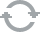
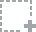
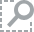
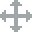
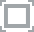
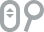

In [2]:
output_notebook()

# Read HDF File

In [3]:
#df represents the 'DataFrame'
data = pd.read_hdf('/Users/MarkWarfel/Desktop/GLE3N/Test_Build/HDF_data/NY_Counties.hdf', 'df')


color data in here

In [10]:

low_limit =  1.0
high_limit = 6.0
step_range = high_limit - low_limit
palette_len = len(POP_COLOR_RANGE)
step = step_range / (palette_len-2)

def color_pop(data, columns_to_colorify, palette):
    
    def _get_color(value, palette):

        if value == value:
            if value <= low_limit: #step1
                return palette[0]
            elif value <= (low_limit + step) and value > (low_limit): #step2
                return palette[1]
            elif value <= (low_limit + step*2) and value > (low_limit + step): #step3
                return palette[2]
            elif value <= (low_limit + step*3) and value > (low_limit + step*2): #step4
                return palette[3]
            elif value <= (low_limit + step*4) and value > (low_limit + step*3): #step5
                return palette[4]
            elif value <= (low_limit + step*5) and value > (low_limit + step*4): #step6
                return palette[5]
            elif value <= (low_limit + step*6) and value > (low_limit + step*5): #step7
                return palette[6]
            elif value <= (low_limit + step*7) and value > (low_limit + step*6): #step8
                return palette[7]
            elif value <= (low_limit + step*8) and value > (low_limit + step*7): #step9
                return palette[8]
            elif value <= (low_limit + step*9) and value > (low_limit + step*8): #step10
                return palette[9]
            elif value <= (low_limit + step*10) and value > (low_limit + step*9): #step11
                return palette[10]
            elif value >= (high_limit): #step12
                return palette[11]
            
        else:
            palette = NODATA_COLOR
            
        #index = int(value / bin_factor)
        #return palette[index-1]
    
    for column_name in columns_to_colorify:
        color_name = '%s_color' % column_name
        data[color_name] = data['%s' % column_name].apply(_get_color, args=([palette]))
    return data
      
columns_to_label = ["NORM01", "NORM02", "NORM03", "NORM04", "NORM05", "NORM06", "NORM07", "NORM08", "NORM09", "NORM10", "NORM11"]   
columns_to_colorify = [] 

for column in columns_to_label:
    name = "NORM20" + column[4:6]
    data[name] = data[column]
    columns_to_colorify.append(name)
    
color_pop(data, columns_to_colorify, POP_COLOR_RANGE)   

data['active_year'] = 2001
data['active_value'] = data['NORM2001']
data['active_color'] = data['NORM2001_color']
percents = ["<%s" % (low_limit) + "%", 
            "%s" % ((low_limit+step)) + "%",
            "%s" % ((low_limit+step*2)) + "%", 
            "%s" % ((low_limit+step*3)) + "%", 
            "%s" % ((low_limit+step*4)) + "%", 
            "%s" % ((low_limit+step*5)) + "%", 
            "%s" % ((low_limit+step*6)) + "%", 
            "%s" % ((low_limit+step*7)) + "%", 
            "%s" % ((low_limit+step*8)) + "%", 
            "%s" % ((low_limit+step*9)) + "%", 
            "%s" % ((low_limit+step*10)) + "%", 
            ">%s" % ((high_limit)) + "%"]

#Setup Plot Function

In [11]:
def setup_map_plot():
    #plot_width sets the size of the drawing
    plot_width = 718
    #the 'x' extents of the shapefile
    x_start, x_end = (-79.9, -71.8)
    #the 'y' extents of the shapefile
    y_start, y_end = (40.4, 45.1)
    aspect_ratio = (x_end - x_start) / (y_end - y_start)
    plot_height=(plot_width / aspect_ratio)
    x_range = Range1d(x_start, x_end)
    y_range = Range1d(y_start, y_end)
    #the function inherits constants from above and creates a "Plot" object
    return Plot(x_range=x_range, y_range=y_range, title="", plot_height=int(plot_height), plot_width=plot_width, **PLOT_FORMATS)

#Define Function to Make Map

In [12]:
def make_map(source, fill_color_string = "active_color"):
    
    boundry = Patches(
        xs='xs', 
        ys='ys',
        fill_color=fill_color_string,
        line_color=DK_GRAY,
        line_width=0.5,
    )   
    
    selected_boundry = Patches(
        xs='xs', 
        ys='ys',
        fill_color=fill_color_string,
        line_color=BLACK,
        line_width=1,
    )
    
    non_selected_boundry = Patches(
        xs='xs', 
        ys='ys',
        fill_color=fill_color_string,
        line_color=WHITE,
        line_width=0.001,
        fill_alpha=1.0,
    )
    
    #ttip written in HTML CSS
    ttip = """
    <div>
        <span style="font-size: 17px; font-family: helvetica; font-weight: bold;">@NAME</span>
        <span style="font-size: 15px; font-family: helvetica; color: #7E7E7E;">County</span>
    </div>
    <div>
        <span style="font-size: 15px; font-family: helvetica; font-weight: bold;">@active_year</span>
        <span style="font-size: 15px; font-family: helvetica; color: #7E7E7E;">@active_value</span>
    </div>
    """
    
    map_box = setup_map_plot()
    map_box.add_glyph(source, boundry, selection_glyph=selected_boundry, nonselection_glyph=non_selected_boundry)
    map_box.add_tools(TapTool())
    map_box.add_tools(HoverTool(tooltips=ttip))
    
    year_callback = Callback(code="""
        var year = year_slider.get('value');
        var data = source.get('data');
        var i = %d;
        data['active_color'] = data['NORM' + year + '_color'];
        data['active_value'] = data['NORM' + year];
        while (--i >= 0) {
            data['active_year'][i] = year;}
        source.trigger('change');
        """ % len(data))
    
    year_slider = Slider(start=2001, end=2012, value=1, step=1, title="Year", callback=year_callback)
    
    year_callback.args={'year_slider': year_slider, 'source': source}

    layout = vplot(map_box, year_slider)
    
    return layout

In [13]:
#convert the read data into a ColumnDataSource which is needed to feed into bokeh
source = ColumnDataSource(data)
#data = the original pandas dataframe
#source = data suitable to be used by Bokeh

In [14]:
map_plot = make_map(source, "active_color")

In [15]:
html = file_html(map_plot, CDN, __version__)
display(HTML(html))

In [136]:
file_name = __version__+".html"
Html_file= open(file_name,"w")
Html_file.write(html)
Html_file.close()